In [124]:
!pip install torch
!pip install torch-geometric
!pip install geopy
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 32.9 MB/s eta 0:00:00 MB/s eta 0:00:01


In [ ]:
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import plotly.graph_objs as go

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

import networkx as nx
from geopy.distance import geodesic

import concurrent.futures

# FIX SEED
torch.manual_seed(1)
np.random.seed(1)

### Preprocess and sampling

In [ ]:
if input("Do you want to preprocess the data? Press Enter to continue.") != "":
    raise Exception("Stop")

In [97]:
# Import complete data
df=pd.read_csv('data.csv')

In [98]:
# Sample random rows from the dataframe
df=df.sample(n=100000)

In [99]:
# Remove rows with missing values
df = df.dropna()

# Reset the index
df = df.reset_index(drop=True)

In [100]:
df['date'].apply(lambda x: re.sub(r'^\d{4}-\d{2}-\d{2}\s', '', x)).str.split('.').str[0]

0        01:14:32
1        02:12:06
2        13:25:41
3        01:17:15
4        11:22:11
           ...   
91321    02:19:02
91322    01:45:15
91323    12:27:17
91324    01:08:18
91325    13:02:13
Name: date, Length: 91326, dtype: object

In [101]:
# Create a new column for the day and hour
df['day'] = df['date'].apply(lambda x: re.sub(r'\s.*$', '', x))
df['day']=pd.to_datetime(df['day'])

df['hour']= df['date'].apply(lambda x: re.sub(r'^\d{4}-\d{2}-\d{2}\s', '', x)).str.split('.').str[0]


In [102]:
df.drop('date', axis=1, inplace=True)

In [39]:
# Create timestamp of the date
# df['date'] = pd.to_datetime(df['date'])

In [103]:
# Move day and hour columns after file column
cols = df.columns.tolist()
cols = cols[:1] + cols[-2:] + cols[1:-2]
df = df[cols]

L’errore dovuto all’arrotondamento della latitudine e longitudine dipende dalla precisione delle cifre decimali rimosse. Ogni cifra decimale rappresenta una frazione di grado, e ridurre il numero di cifre porta a un errore maggiore in termini di distanza geografica. 

In generale, possiamo stimare così:

**1. Introduzione all'errore per cifra decimale tolta**
- **Latitudine** e **longitudine** sono espresse in gradi, e ogni grado di latitudine corrisponde approssimativamente a 111 km di distanza sulla superficie terrestre. La distanza associata a un grado di longitudine varia con la latitudine, raggiungendo 111 km all’equatore e riducendosi a zero ai poli.
- Ogni cifra decimale rappresenta una frazione di grado. Per esempio, 1 decimale rappresenta circa 11 km, 2 decimali 1.1 km, e così via.

**2. Stima dell’errore di arrotondamento**
Ecco una stima di errore in distanza per ogni cifra decimale tolta:

| Cifre decimali | Errore approssimativo (km) |
|----------------|----------------------------|
| 0 decimali     | 111 km                      |
| 1 decimale     | 11.1 km                     |
| 2 decimali     | 1.11 km                     |
| 3 decimali     | 111 m                       |
| 4 decimali     | 11.1 m                      |
| 5 decimali     | 1.11 m                      |
| 6 decimali     | 0.11 m (11 cm)              |

**Spiegazione dell’errore**
- **0 decimali**: Un’approssimazione intera può portare a uno spostamento massimo di 111 km, una distanza significativa.
- **1 decimale**: Tolta una cifra decimale, la precisione cala a circa 11 km, un errore approssimabile alla larghezza di una città di medie dimensioni.
- **2 decimali**: Due decimali garantiscono una precisione entro 1.1 km, utile per aree urbane o quartieri.
- **3 decimali**: Con tre decimali, siamo entro un errore di circa 111 metri, sufficientemente preciso per una zona cittadina.
- **4 decimali**: Con quattro decimali, l’errore è di circa 11 metri, utile per localizzare edifici.
- **5 decimali**: Cinque decimali permettono una precisione entro 1 metro, adeguata per localizzazioni precise come un ingresso.
- **6 decimali**: Con sei decimali, l’errore scende a circa 10 cm, che può essere utile per operazioni di alta precisione, come la geolocalizzazione in archeologia o robotica.

**Conclusione**
Ogni cifra decimale tolta riduce significativamente la precisione geografica, con un errore che aumenta di un fattore di circa 10 per ogni cifra eliminata.

In [129]:
df['lat']=df['lat'].round(1)
df['lon']=df['lon'].round(1)

In [130]:
# Save the sampled data
df.to_csv('data_sampled_lan_lot_round.csv', index=False)

### Data analysis

In [84]:
# Import the data
df=pd.read_csv('data_sampled_lan_lot_round.csv', parse_dates=['day'])

In [85]:
#df=df[df['day'] == '2015-01-03'].sample(10)
df=df.sample(300)

In [86]:
# Display the first few rows of the dataframe
df

file        day      hour  \
5535   10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150721... 2015-07-21  13:21:57   
5033   10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20151012... 2015-10-12  02:38:56   
50280  10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150420... 2015-04-20  12:07:34   
73756  10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150122... 2015-01-22  12:59:51   
87595  10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150122... 2015-01-22  12:58:34   
...                                                  ...        ...       ...   
3284   10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150415... 2015-04-15  11:56:48   
26818  10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150421... 2015-04-21  11:53:15   
35532  10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20151026... 2015-10-26  01:31:04   
19475  10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150421... 2015-04-21  02:00:37   
25743  10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150407... 2015-04-07  12:42:58   

       atrack  xtrack   lat   lon    surf_alt  solar_zenith_angle  \
5535       85      47  45.9  -7.3    0.000000           27.184480   
5033       62      62  46.8 -11.6    0.000000          132.147100   
50280      31      81  50.1  19.6  293.160700           42.532814   
73756     128      15  46.5  -9.7    0.000000           66.239220   
87595      99      40  43.4  -1.4   77.202415           63.782660   
...       ...     ...   ...   ...         ...                 ...   
3284       59      58  33.5  19.6    0.000000           29.283577   
26818     114      77  66.6  16.8  726.916300           55.684616   
35532      20      61  61.6  11.2  496.793550          123.617290   
19475      10      25  53.5  10.6   39.265600          106.028380   
25743      18      28  15.9   6.3  477.249200           18.498255   

       solar_azimuth_angle                           satellite_position  \
5535            204.189150              [4979837.5 -631966.2 5161554.5]   
5033             44.262375              [4926784.  -735582.  5198472.5]   
50280           212.487820           [4654095.5   875031.44 5423641.5 ]   
73756           182.438400           [4820214.   -143695.55 5346302.  ]   
87595           190.831530  [5.2249270e+06 3.4008398e+03 4.9546555e+06]   
...                    ...                                          ...   
3284            220.259920              [5751892.  1840438.4 3925003.2]   
26818           198.351060           [3024985.    270925.25 6526087.5 ]   
35532            46.092434           [3376475.2   917699.94 6290329.5 ]   
19475            41.922836           [4173940.    352593.22 5855367.  ]   
25743           242.653660              [6824141.  1127034.1 2018651.4]   

                                         air_temp_masked  \
5535   [184.95872 189.78055 210.32678 225.45068 231.5...   
5033   [205.4598  204.24385 203.25613 208.42836 224.1...   
50280  [196.88673 199.12733 214.90541 227.47365 239.9...   
73756  [208.60478 210.22429 202.67555 200.60674 214.6...   
87595  [208.30692 206.73146 202.4545  204.78891 217.7...   
...                                                  ...   
3284   [193.05212 190.87767 210.38853 229.59343 243.2...   
26818  [194.2623  195.56345 207.82611 225.4493  241.9...   
35532  [205.63393 212.21497 222.11913 241.69798 245.9...   
19475  [199.99312 202.00243 213.19138 224.97221 237.9...   
25743  [198.43158 195.89157 204.56474 222.26553 233.7...   

       surf_air_temp_masked  surf_temp_masked  surf_spec_hum_masked  \
5535              289.77774         291.91710              0.007498   
5033              289.81256         290.33340              0.012693   
50280             283.76273         286.82007              0.004170   
73756             282.12520         285.32086              0.007440   
87595             277.87128         280.69333              0.004770   
...                     ...               ...                   ...   
3284              289.29697         290.27000              0.010057   
26818             273.68800         273.44220              0

In [87]:
# Display the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 5535 to 25743
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   file                                         300 non-null    object        
 1   day                                          300 non-null    datetime64[ns]
 2   hour                                         300 non-null    object        
 3   atrack                                       300 non-null    int64         
 4   xtrack                                       300 non-null    int64         
 5   lat                                          300 non-null    float64       
 6   lon                                          300 non-null    float64       
 7   surf_alt                                     300 non-null    float64       
 8   solar_zenith_angle                           300 non-null    float64       
 9  

### Visualization

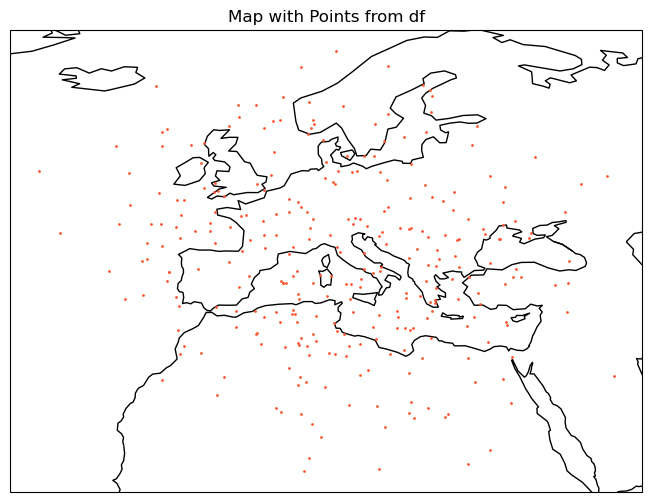

In [88]:
# Create a figure and axis with the PlateCarree projection
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use Plate Carree projection for global map

# Plot the points from df
ax.plot(
    df['lon'], df['lat'],
    'o', color='#FF5733', markersize=1, alpha=1,
    transform=ccrs.PlateCarree()    # Data coordinate system
)

# Add coastlines and gridlines for context
ax.coastlines()
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Set a title
plt.title("Map with Points from df")

# Show the plot
plt.show()


### Graph implementation

In [153]:
# Define a threshold for spatial and temporal proximity
spatial_threshold_km = 500  # For example, nodes within 10 km
temporal_threshold_hours = 24 * 28  # For example, nodes within 24 hours

In [154]:
# Initialize lists for PyTorch Geometric
node_features = []
edges = []

In [155]:
# Step 1: Create a dictionary to map each (lat, lon, day, hour) combination to a node index
node_mapping = {}
index = 0
for _, row in df.iterrows():
    node_id = (row['lat'], row['lon'], row['day'])
    node_mapping[node_id] = index

    # Collect node features as a list of feature vectors
    feature_vector = torch.tensor([
        row['solar_zenith_angle'],
        row['solar_azimuth_angle'],
        # row['air_temp_masked'][0],
        row['surf_air_temp_masked'],
        row['surf_temp_masked'],
        row['surf_spec_hum_masked'],
        row['h2o_vap_tot_masked'],
        row['cloud_liquid_water_masked'],
        row['atmosphere_mass_content_of_cloud_ice_masked']
    ], dtype=torch.float)
    
    node_features.append(feature_vector)
    index += 1

# Convert node features to a tensor
x = torch.stack(node_features)


In [156]:
len(node_mapping.keys())

300

In [157]:
import concurrent.futures
from geopy.distance import geodesic
import torch

# Function to check proximity and return edges if the proximity thresholds are met
def check_proximity(pair):
    i, j = pair
    node1, node2 = node_ids[i], node_ids[j]
    
    # Calculate spatial and temporal distances
    spatial_dist = geodesic((node1[0], node1[1]), (node2[0], node2[1])).km
    temporal_dist = abs((node1[2] - node2[2]).total_seconds()) / 3600
    
    # Debugging information
    print(f"Checking pair {i} and {j}: Spatial distance = {spatial_dist} km, Temporal distance = {temporal_dist} hours")
    
    # Return edge if within proximity thresholds
    if spatial_dist <= spatial_threshold_km and temporal_dist <= temporal_threshold_hours:
        return [node_mapping[node1], node_mapping[node2]]
    return None  # Return None if no edge is created

# Prepare pairs of indices to process
node_ids = list(node_mapping.keys())
node_pairs = [(i, j) for i in range(len(node_ids)) for j in range(i + 1, len(node_ids))]
print(f"Number of node pairs to check: {len(node_pairs)}")

# Use ThreadPoolExecutor for parallel processing in Jupyter
edges = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(check_proximity, node_pairs)
    
    # Collect non-None results (valid edges)
    edges = [edge for edge in results if edge is not None]

# Convert edges to a PyTorch tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


Number of node pairs to check: 44850
Checking pair 0 and 1: Spatial distance = 345.7215692005979 km, Temporal distance = 1992.0 hours
Checking pair 0 and 2: Spatial distance = 2048.961758372387 km, Temporal distance = 2208.0 hours
Checking pair 0 and 3: Spatial distance = 196.87109750933018 km, Temporal distance = 4320.0 hours
Checking pair 0 and 4: Spatial distance = 544.0494812126598 km, Temporal distance = 4320.0 hours
Checking pair 0 and 5: Spatial distance = 1947.2941036667712 km, Temporal distance = 168.0 hours
Checking pair 0 and 6: Spatial distance = 139.6819496964873 km, Temporal distance = 4656.0 hours
Checking pair 0 and 7: Spatial distance = 2051.5748160445355 km, Temporal distance = 1968.0 hours
Checking pair 0 and 8: Spatial distance = 1405.8760689655771 km, Temporal distance = 4344.0 hours
Checking pair 0 and 9: Spatial distance = 3230.4127411310997 km, Temporal distance = 120.0 hours
Checking pair 0 and 10: Spatial distance = 2121.482090821961 km, Temporal distance = 23

In [158]:
# Step 3: Create a PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[300, 8], edge_index=[2, 492])


/tmp/ipykernel_1889349/2395666141.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



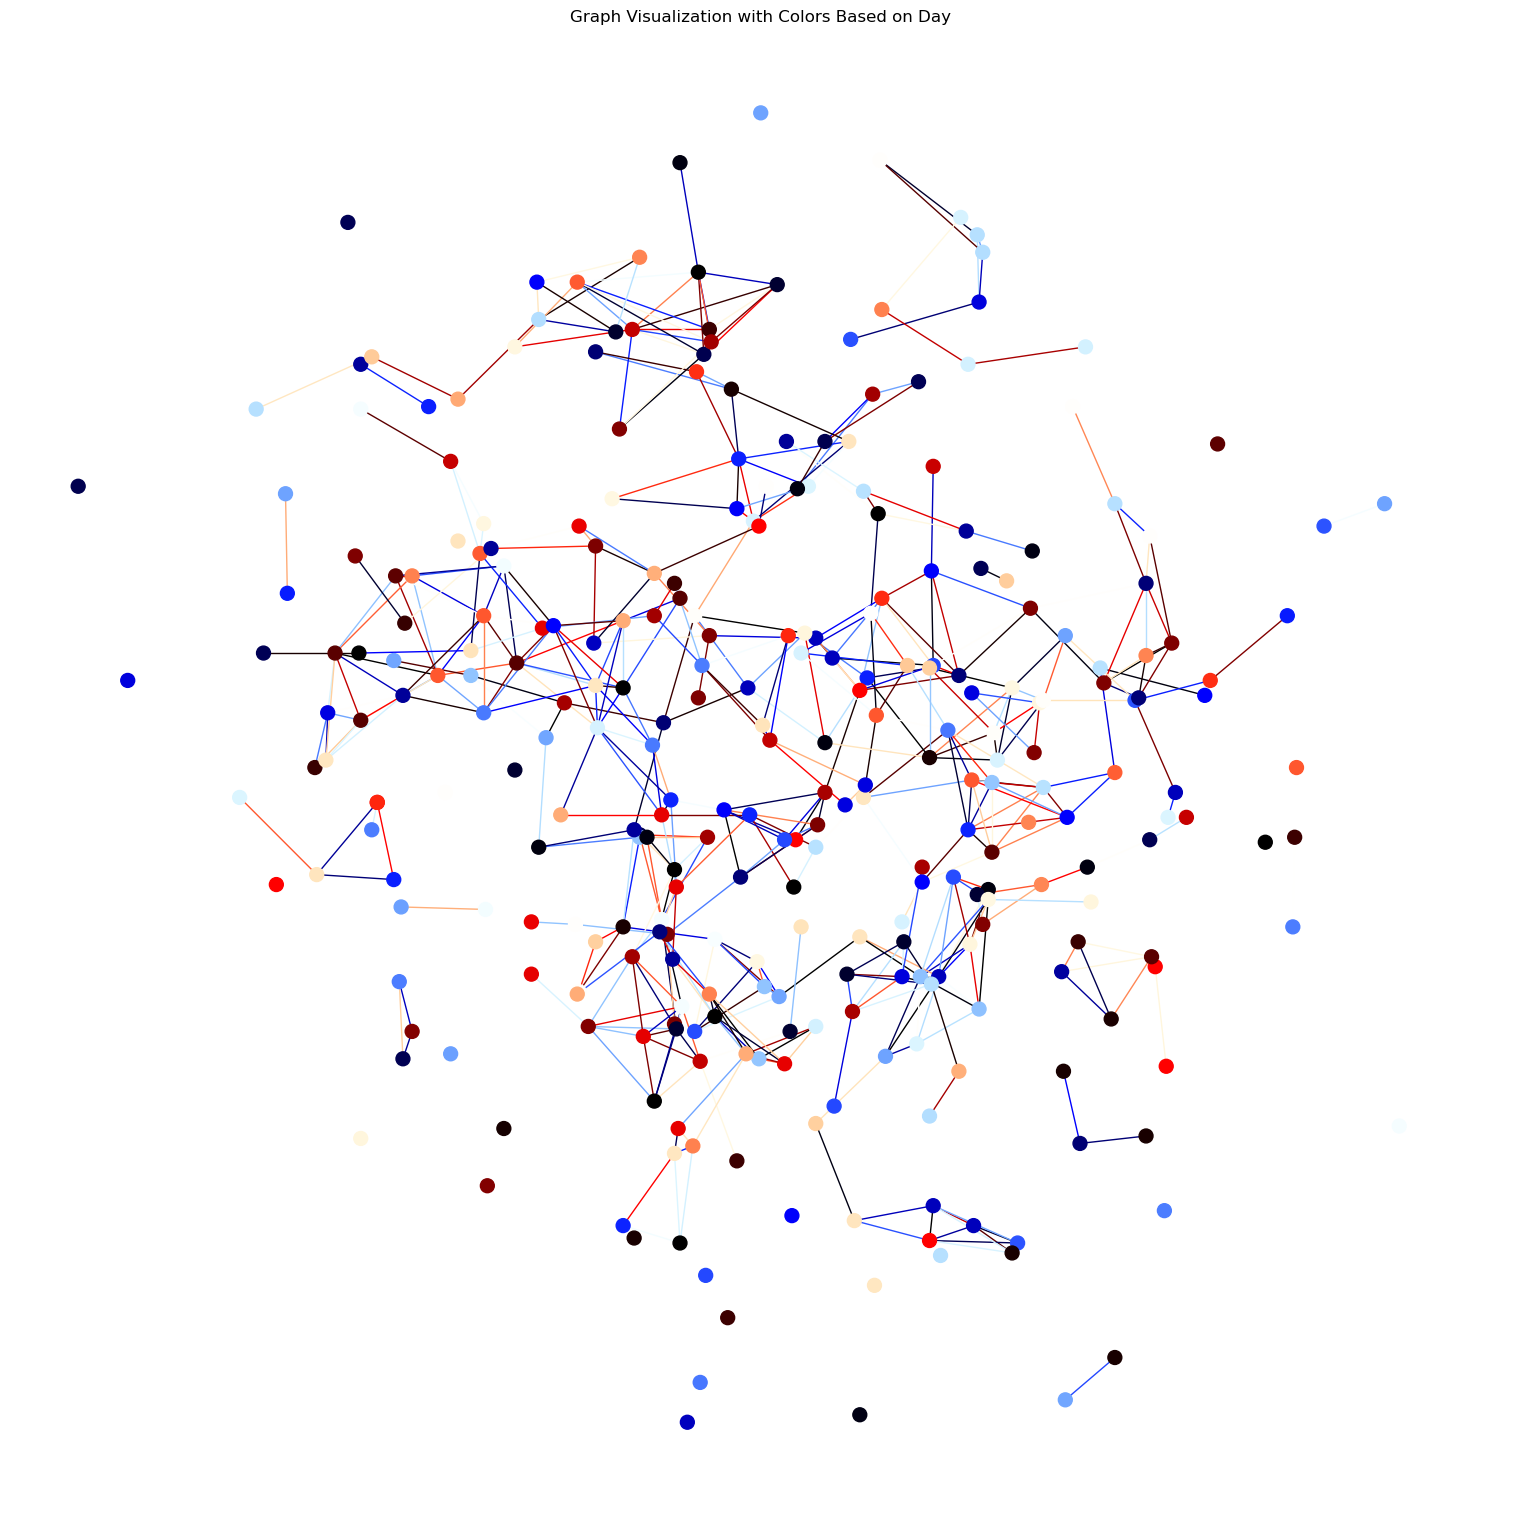

In [159]:
# Convert the PyTorch Geometric data object to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Create a dictionary with (lat, lon) positions for each node
positions = {node_mapping[node_id]: (node_id[1], node_id[0]) for node_id in node_ids}  # (lon, lat) for x, y

# Extract the days from `node_id` and find unique days
days = [node_id[2] for node_id in node_ids]
unique_days = list(set(days))
day_to_color = {day: i for i, day in enumerate(unique_days)}

# Assign a color to each node based on the day
node_colors = [day_to_color[node_id[2]] for node_id in node_ids]

# Normalize colors for colormap
norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))
cmap = cm.get_cmap("flag", len(unique_days))
mapped_colors = [cmap(norm(color)) for color in node_colors]

# Create a label dictionary with (lat, lon, day) as labels for each node
labels = {node_mapping[node_id]: f"{node_id[0]:.2f}, {node_id[1]:.2f}" for node_id in node_ids}
labels = {node_mapping[node_id]: "" for node_id in node_ids}

# Plot the graph
plt.figure(figsize=(15, 15))
nx.draw(G, pos=positions, with_labels=True, labels=labels, node_size=100, 
        font_size=10, node_color=mapped_colors, edge_color=mapped_colors)
plt.title("Graph Visualization with Colors Based on Day")
plt.show()


In [161]:

# Convert the PyTorch Geometric data object to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Create a dictionary with (lat, lon) positions for each node
positions = {node_mapping[node_id]: (node_id[1], node_id[0]) for node_id in node_ids}  # (lon, lat) for x, y

# Extract the days from `node_id` and find unique days
days = [node_id[2] for node_id in node_ids]

# Convert `days` from Timestamps to integers (e.g., days since the first date)
start_day = min(days)  # Find the earliest timestamp
days_numeric = [(day - start_day).days for day in days]  # Convert Timestamps to days since `start_day`

# Find unique days in the converted numeric form and assign colors
unique_days_numeric = list(set(days_numeric))
day_to_color = {day: i for i, day in enumerate(unique_days_numeric)}
node_colors = [day_to_color[day_numeric] for day_numeric in days_numeric]

# Normalize colors for colormap
norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))
cmap = cm.get_cmap("flag", len(unique_days_numeric))
mapped_colors = [cmap(norm(color))[:3] for color in node_colors]  # Use RGB for Plotly

# 3D Plot Setup
node_x = []
node_y = []
node_z = []
node_color_rgb = []

for i, node in enumerate(positions.keys()):
    x, y = positions[node]
    z = days_numeric[i]  # Use the numeric day as the z-axis
    node_x.append(x)
    node_y.append(y)
    node_z.append(z)
    node_color_rgb.append(mapped_colors[i])

# Edge coordinates for 3D lines
edge_x = []
edge_y = []
edge_z = []

for edge in G.edges():
    x_vals = [positions[edge[0]][0], positions[edge[1]][0], None]
    y_vals = [positions[edge[0]][1], positions[edge[1]][1], None]
    z_vals = [days_numeric[list(positions.keys()).index(edge[0])], 
              days_numeric[list(positions.keys()).index(edge[1])], None]
    edge_x.extend(x_vals)
    edge_y.extend(y_vals)
    edge_z.extend(z_vals)

# Plotting nodes
node_trace = go.Scatter3d(
    x=node_x, y=node_y, z=node_z,
    mode='markers',
    marker=dict(size=5, color=node_color_rgb, opacity=0.8),
    text=[f"{pos[0]:.2f}, {pos[1]:.2f}, Day: {z}" for pos, z in zip(positions.values(), days_numeric)],
    hoverinfo='text'
)

# Plotting edges
edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
)

# Creating the figure
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title="Interactive 3D Graph Visualization with Colors Based on Day",
    scene=dict(
        xaxis_title="Longitude",
        yaxis_title="Latitude",
        zaxis_title="Days (since start date)"
    ),
    showlegend=False
)

# Show plot
fig.show()


/tmp/ipykernel_1889349/907077589.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

